In [1]:
#import required libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib


In [2]:
#function to load the data into a Pandas Dataframe
def load_f(file):
    return pd.read_csv(file)

#scatter plots 
def scatter_data(df, col):
    plt.figure(figsize = (12,8))
    plt.scatter(df[col], df['cc_cons'] )
    plt.ylabel('credit card consumption')
    plt.xlabel(col)

#regression plots
def reg_data(df, col):
    plt.figure(figsize=(12,8))
    sns.regplot(x=df[col], y = df['cc_cons'], data = df, line_kws = {'color' : 'red'})    
    plt.ylim(0,)
    
#residual plots 
def res_data(df,col):
    plt.figure(figsize=(12,8))
    sns.residplot(x=df[col], y = df['cc_cons'], data = df)
    plt.show()

#distribution plots 
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.show()
    plt.close()

In [3]:
#load data
print("Loading data..")
train_df = load_f('train.csv')
test_df = load_f('test.csv')


#verify data is laoded 
train_df.head()

Loading data..


FileNotFoundError: [Errno 2] File train.csv does not exist: 'train.csv'

In [4]:
test_df.head()

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active
0,6975,saving,M,36,447,17942.70,1170.0,1656.00,NaN,4551.00,...,3.0,7.0,10000.0,17316.44,5154.0,2.0,8.0,5000.0,NaN,0.00
1,43223,current,M,31,233,44870.36,NaN,34177.00,NaN,25889.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2,45502,current,M,26,823,1073.00,2442.0,4141.00,390.0,6740.29,...,4.0,22.0,26926.0,33981.00,37762.0,3.0,15.0,29352.0,NaN,2885.82
3,12368,current,M,39,878,33060.58,NaN,3797.12,NaN,291.00,...,4.0,8.0,57185.0,52927.00,89425.0,7.0,11.0,32696.0,NaN,0.00
4,40415,current,M,44,404,18236.90,NaN,30513.30,NaN,20395.28,...,1.0,5.0,45000.0,31656.69,34275.0,3.0,4.0,19000.0,NaN,3342.58


See lengths & dtypes of the loaded data frames

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32820 entries, 0 to 32819
Data columns (total 44 columns):
id                       32820 non-null int64
account_type             32820 non-null object
gender                   32820 non-null object
age                      32820 non-null int64
region_code              32820 non-null int64
cc_cons_apr              32820 non-null float64
dc_cons_apr              13768 non-null float64
cc_cons_may              32820 non-null float64
dc_cons_may              15481 non-null float64
cc_cons_jun              32820 non-null float64
dc_cons_jun              11523 non-null float64
cc_count_apr             30421 non-null float64
cc_count_may             31667 non-null float64
cc_count_jun             31230 non-null float64
dc_count_apr             13768 non-null float64
dc_count_may             15481 non-null float64
dc_count_jun             17323 non-null float64
card_lim                 32811 non-null float64
personal_loan_active     2742 non-n

Check the shape of the dataframes

In [6]:
print(train_df.shape)
print(test_df.shape)

(32820, 44)
(14067, 43)


The data in the test_df will be good for testing the created models as it does not have pre-existing target variable, cc_cons.

Check for missing values

In [7]:
#store the sum of missing values in each column - 
missing_val = train_df.isnull().sum()
missing_val

id                           0
account_type                 0
gender                       0
age                          0
region_code                  0
cc_cons_apr                  0
dc_cons_apr              19052
cc_cons_may                  0
dc_cons_may              17339
cc_cons_jun                  0
dc_cons_jun              21297
cc_count_apr              2399
cc_count_may              1153
cc_count_jun              1590
dc_count_apr             19052
dc_count_may             17339
dc_count_jun             15497
card_lim                     9
personal_loan_active     30078
vehicle_loan_active      31974
personal_loan_closed     29937
vehicle_loan_closed      31195
investment_1             31394
investment_2             30482
investment_3             31488
investment_4             32414
debit_amount_apr          1890
credit_amount_apr         3302
debit_count_apr           1758
credit_count_apr          1758
max_credit_amount_apr     3302
debit_amount_may          2301
credit_a

We can see that a lot of columns in our data have a lot of missing values. By using the rule of thumb for handling missing data, we will set the threshold of 70% & remove the rows and columns that are above the threshold.

In [52]:
threshold = 0.7

#dropping columns above threshold
clear_train_df = train_df[train_df.columns[train_df.isnull().mean() < threshold]]

#dropping rows above threshold
clear_train_df = train_df.loc[train_df.isnull().mean(axis = 1) < threshold]

In [53]:
print(clear_train_df.shape)

(32820, 35)


Let us check again of how many missing values are left in the data now

In [54]:
clear_train_df.isnull().sum()

id                           0
account_type                 0
gender                       0
age                          0
region_code                  0
cc_cons_apr                  0
dc_cons_apr              19052
cc_cons_may                  0
dc_cons_may              17339
cc_cons_jun                  0
dc_cons_jun              21297
cc_count_apr              2399
cc_count_may              1153
cc_count_jun              1590
dc_count_apr             19052
dc_count_may             17339
dc_count_jun             15497
card_lim                     9
debit_amount_apr          1890
credit_amount_apr         3302
debit_count_apr           1758
credit_count_apr          1758
max_credit_amount_apr     3302
debit_amount_may          2301
credit_amount_may         3405
credit_count_may          2071
debit_count_may           2071
max_credit_amount_may     3405
debit_amount_jun          2195
credit_amount_jun         1543
credit_count_jun          1528
debit_count_jun           1528
max_cred

In [55]:
clear_train_df.head()

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
0,23334,saving,M,63,305,7695.00,NaN,479.00,NaN,622.0,...,3.0,2.0,45000.0,20215.85,1279.37,7.0,3.0,470.0,0.00,435
1,20329,current,M,33,326,52702.00,988.72,29873.00,NaN,1087.0,...,6.0,10.0,150000.0,122037.66,55390.00,8.0,19.0,27000.0,4963.33,1921
2,17679,current,M,44,264,10800.49,3215.52,21659.64,1607.0,1168.0,...,2.0,7.0,13800.0,46827.00,29297.91,6.0,19.0,20800.0,0.00,1970
3,16428,saving,M,44,233,20936.00,NaN,2094.00,NaN,11778.5,...,1.0,1.0,19300.0,5426.55,7544.00,3.0,1.0,5300.0,1238.18,21579
4,18721,saving,F,35,324,1183.83,NaN,3656.29,NaN,945.0,...,2.0,3.0,3000.0,26178.05,53483.00,4.0,4.0,45000.0,0.00,1814


We can see that the rest of the columns with missing values are numerical. We will go ahead and impute the missing values in these columns with the median of the column. We are choosing mean over median as the averages of the column are more sensitive to outliers.

In [34]:
#Replace all the missing values with the median of the columns.
imputer = SimpleImputer(missing_values = 'NaN', strategy = 'median')
imputer = imputer.fit(clean_train_df.iloc[:, 6:33])
#clean_train_df.iloc[:, 6:33] = Imputer.transform(clean_train_df.iloc[:, 6:33]).ravel()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [56]:
clear_train_df.iloc[:, 6:33] = clear_train_df.iloc[:, 6:33].apply(lambda x: x.fillna(x.median()), axis = 0)

In [57]:
clear_train_df.head()

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
0,23334,saving,M,63,305,7695.00,2282.16,479.00,2129.0,622.0,...,3.0,2.0,45000.0,20215.85,1279.37,7.0,3.0,470.0,0.00,435
1,20329,current,M,33,326,52702.00,988.72,29873.00,2129.0,1087.0,...,6.0,10.0,150000.0,122037.66,55390.00,8.0,19.0,27000.0,4963.33,1921
2,17679,current,M,44,264,10800.49,3215.52,21659.64,1607.0,1168.0,...,2.0,7.0,13800.0,46827.00,29297.91,6.0,19.0,20800.0,0.00,1970
3,16428,saving,M,44,233,20936.00,2282.16,2094.00,2129.0,11778.5,...,1.0,1.0,19300.0,5426.55,7544.00,3.0,1.0,5300.0,1238.18,21579
4,18721,saving,F,35,324,1183.83,2282.16,3656.29,2129.0,945.0,...,2.0,3.0,3000.0,26178.05,53483.00,4.0,4.0,45000.0,0.00,1814


Now, we can see that all the missing values in the rest of the numerical columns have been replaced the median of their columns. Let us do a quick check to see if we are still left with any missing values.

In [58]:
#check if any missing values are left
clear_train_df.isnull().sum()

id                       0
account_type             0
gender                   0
age                      0
region_code              0
cc_cons_apr              0
dc_cons_apr              0
cc_cons_may              0
dc_cons_may              0
cc_cons_jun              0
dc_cons_jun              0
cc_count_apr             0
cc_count_may             0
cc_count_jun             0
dc_count_apr             0
dc_count_may             0
dc_count_jun             0
card_lim                 0
debit_amount_apr         0
credit_amount_apr        0
debit_count_apr          0
credit_count_apr         0
max_credit_amount_apr    0
debit_amount_may         0
credit_amount_may        0
credit_count_may         0
debit_count_may          0
max_credit_amount_may    0
debit_amount_jun         0
credit_amount_jun        0
credit_count_jun         0
debit_count_jun          0
max_credit_amount_jun    0
emi_active               0
cc_cons                  0
dtype: int64

We can see that our dataset is now clear of all the missing values. 

Exploratory Data Anlysis

Descriptive statistics of quantitative data

In [59]:
clear_train_df.describe()

,id,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
count,32820.000000,32820.000000,32820.000000,32820.000000,32820.000000,3.282000e+04,32820.000000,32820.000000,32820.000000,32820.000000,...,32820.000000,32820.000000,3.282000e+04,3.282000e+04,3.282000e+04,32820.000000,32820.000000,3.282000e+04,3.282000e+04,32820.000000
mean,23450.929616,35.951676,554.854327,16661.907189,3727.529773,1.441190e+04,3782.998580,9031.179889,2827.259072,9.004144,...,4.018739,13.749604,4.765338e+04,7.547919e+04,7.428948e+04,5.731993,15.861700,4.390353e+04,9.567620e+03,6824.631840
std,13495.676061,8.529949,188.220317,25138.435416,7667.686645,2.363688e+04,9808.446086,15720.847307,6230.989659,10.404075,...,3.733756,11.110796,1.220130e+05,3.034309e+05,2.990735e+05,4.596735,13.070544,1.187066e+05,2.616736e+05,12459.140593
min,0.000000,22.000000,123.000000,233.970000,10.010000,1.030000e+02,20.000000,51.000000,23.000000,1.000000,...,0.000000,0.000000,1.500000e-01,5.230000e+00,1.188000e+01,0.000000,0.000000,6.000000e-02,0.000000e+00,0.000000
25%,11824.750000,31.000000,425.000000,3712.000000,2282.160000,2.983298e+03,2129.000000,1637.875000,1832.000000,3.000000,...,2.000000,6.000000,1.989472e+04,2.635132e+04,2.405212e+04,3.000000,7.000000,1.668150e+04,0.000000e+00,1285.000000
50%,23478.500000,34.000000,575.000000,8912.790000,2282.160000,7.332298e+03,2129.000000,4147.487500,1832.000000,7.000000,...,3.000000,11.000000,3.000000e+04,4.593499e+04,4.295500e+04,5.000000,13.000000,2.687600e+04,1.510650e+02,3141.000000
75%,35096.250000,39.000000,683.000000,19932.060000,2282.160000,1.684785e+04,2129.000000,10126.250000,1832.000000,12.000000,...,5.000000,18.000000,4.900000e+04,7.978210e+04,7.769936e+04,7.000000,21.000000,4.506050e+04,4.176868e+03,7349.250000
max,46886.000000,224.000000,977.000000,804712.580000,366223.160000,1.117246e+06,911223.490000,382914.100000,301991.940000,1012.000000,...,71.000000,171.000000,1.285103e+07,3.986881e+07,3.933931e+07,117.000000,164.000000,1.293238e+07,4.468722e+07,408630.000000


The minimum, maximum and the range of these numbers all seem appropriate for their corresponding columns except for the maximum of age, i.e, 224, seems suspicious. The mean and standard deviation of do not indicate anything wrong.

Is the target variable normally distributed?

In [60]:
#print the kurtosis & skewness of the target variable, cc_cons
print('Average Spend Skewness:', clear_train_df['cc_cons'].skew())
print('Average Spend kurtosis:', clear_train_df['cc_cons'].kurt())
print('\n')

if -0.5 <= clear_train_df['cc_cons'].skew() <= 0.5:
    print('Target variable distribution is approximately symmetric')
elif -0.5 > clear_train_df['cc_cons'].skew() or train_df['cc_cons'].skew() > 0.5:
    print('Target variable distribution is skewed')


('Average Spend Skewness:', 7.518036222730054)
('Average Spend kurtosis:', 109.13663856369278)


Target variable distribution is skewed


In [62]:
#entries where age is greater than 200
wierd_age = clear_train_df[clear_train_df['age'] > 200]
wierd_age

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
2496,41928,current,M,221,723,3801.500,4369.00,5440.00,2129.00,652.00,...,3.0,18.0,37200.0,131641.75,122885.00,14.0,34.0,37883.0,0.00,3971
3205,35592,current,M,222,526,30425.880,27123.00,321.00,5537.14,10991.00,...,2.0,34.0,38547.0,49030.11,44167.00,3.0,33.0,41247.0,0.00,4430
7071,1479,saving,F,223,523,21008.440,2282.16,9910.25,2129.00,9559.00,...,3.0,11.0,30000.0,45934.99,457.00,1.0,0.0,157.0,0.00,6059
7823,10230,current,M,223,723,2975.000,2282.16,555.00,2129.00,2920.00,...,2.0,8.0,28367.0,88835.14,68370.29,5.0,12.0,28367.0,0.00,250
13862,18776,saving,M,219,623,40445.715,2282.16,3726.00,2129.00,74896.43,...,3.0,11.0,30000.0,45934.99,42955.00,5.0,13.0,26876.0,156.64,18241
16844,28792,current,M,223,233,7517.420,443.00,22789.66,2129.00,18081.00,...,1.0,11.0,20000.0,17175.63,21493.50,4.0,11.0,20000.0,402.91,20721
17934,24920,current,M,224,653,2157.000,2282.16,4998.36,2129.00,3806.18,...,0.0,1.0,30000.0,2482.50,272.00,1.0,2.0,175.0,504.03,2299
22271,32826,current,M,220,725,2670.500,2282.16,2537.00,1579.00,1915.00,...,2.0,8.0,39300.0,24506.12,37110.00,4.0,3.0,16850.0,7450.69,10108
23789,46519,current,M,221,755,33755.300,589.96,14234.34,442.67,231491.00,...,5.0,9.0,50000.0,223030.88,331208.05,8.0,15.0,200000.0,37954.74,4420
25762,28706,saving,M,220,324,9908.980,2282.16,6574.40,2129.00,8689.19,...,0.0,1.0,30000.0,2139.00,4228.00,2.0,1.0,4000.0,5664.20,1916


As we can see above, there are 12 entries with the corresponding age value above 200, which is however not impossible, but suspicious. We may decide to drop these for better computation of our mdoel. 

Visualize target variable (cc_cons)

In [63]:
#We use IQR to identify potential outliers 
stats = clear_train_df['cc_cons'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print 'The upper and lower bounds of possible outliers:', lower_bound, upper_bound

The upper and lower bounds of possible outliers: -7811.375 16445.625


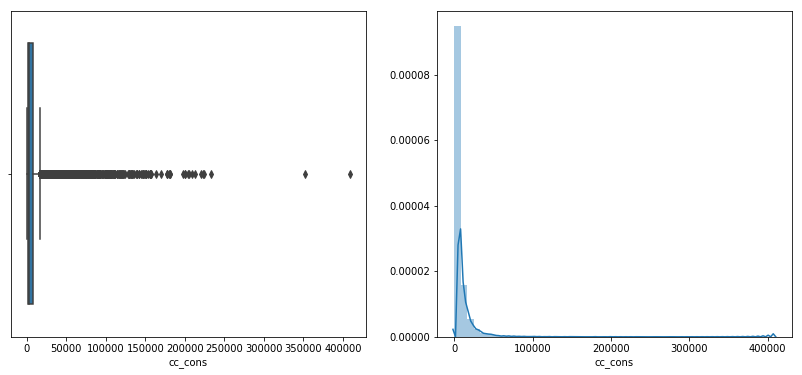

In [64]:
#plot boxplot & distribution plot of the target variable
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.boxplot(clear_train_df['cc_cons'])
plt.subplot(1,2,2)
sns.distplot(clear_train_df['cc_cons'])

In [65]:
clear_train_df['logcc_cons'] = np.log(clear_train_df['cc_cons'] + 1)

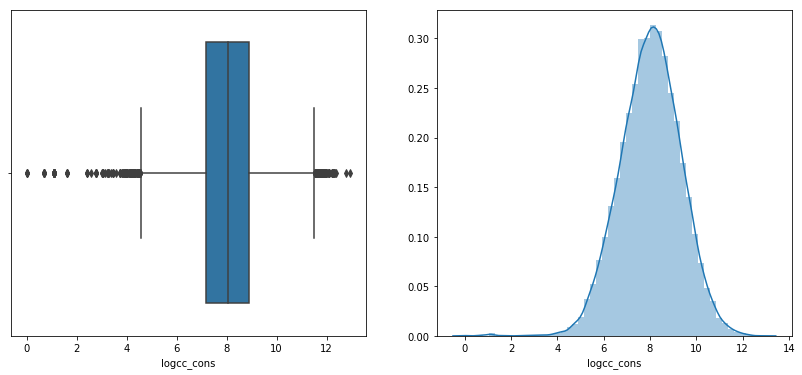

In [66]:
#plot boxplot & distribution plot of the log_target variable
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.boxplot(clear_train_df['logcc_cons'])
plt.subplot(1,2,2)
sns.distplot(clear_train_df['logcc_cons'])

In [67]:
#examine the outliers below the lower_bound
clear_train_df[clear_train_df['cc_cons'] < lower_bound]

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons,logcc_cons


Looks like the outliers below the lower_bound are sorted.

In [70]:
#examine the outliers above the upper_bound with respect to age
clear_train_df.loc[clear_train_df['cc_cons'] > upper_bound, 'age'].value_counts()

35     202
34     201
37     199
33     188
36     170
32     164
38     156
31     154
39     138
40     132
30     131
29     107
41      99
42      90
44      88
28      81
43      75
46      69
47      64
27      60
45      53
49      51
48      49
26      37
53      31
50      30
55      28
51      27
25      26
54      25
52      23
57      22
59      19
56      17
61      12
58      11
24      10
60      10
64      10
62       9
63       8
67       6
66       5
65       5
23       4
68       3
69       3
118      1
120      1
219      1
123      1
223      1
Name: age, dtype: int64

To reduce the effect of the outliers, and for the numerical variables to be compared easily by our model, let us apply standardization


In [130]:
#standardize dataset - 
scaler = StandardScaler()

features = clear_train_df.copy()
train_2d = clear_train_df.columns[~clear_train_df.columns.isin(['gender', 'account_type'])]
feat = features[train_2d]
feat = scaler.fit_transform(feat)


In [131]:
features[train_2d] = feat

In [132]:
features.head()

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,...,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons,logcc_cons
0,-0.008664,saving,M,3.171031,-1.327477,-0.356707,-0.188504,-0.589465,-0.168633,-0.534914,...,-1.057510,-0.021747,-0.182131,-0.244125,0.275854,-0.984037,-0.365895,-0.036564,-0.512855,-1.481210
1,-0.231332,current,M,-0.346042,-1.215904,1.433687,-0.357194,0.654119,-0.168633,-0.505335,...,-0.337479,0.838830,0.153442,-0.063194,0.493403,0.240108,-0.142400,-0.017596,-0.393583,-0.349885
2,-0.427694,current,M,0.943552,-1.545310,-0.233169,-0.066776,0.306633,-0.221853,-0.500183,...,-0.607491,-0.277461,-0.094429,-0.150439,0.058305,0.240108,-0.194630,-0.036564,-0.389650,-0.330686
3,-0.520392,saving,M,0.943552,-1.710013,0.170025,-0.188504,-0.521139,-0.168633,0.174759,...,-1.147514,-0.232384,-0.230872,-0.223178,-0.594342,-1.137055,-0.325206,-0.031832,1.184238,1.494427
4,-0.350483,saving,F,-0.111570,-1.226530,-0.615723,-0.188504,-0.455042,-0.168633,-0.514368,...,-0.967507,-0.365978,-0.162481,-0.069571,-0.376793,-0.907528,0.009237,-0.036564,-0.402171,-0.393568


Relationships with categorical data

In [146]:
def rel_cat(df,col):
    #Make subplots - left be the distribution of samples on the feature and right be the dependance of salary on the feature
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col].value_counts().sort_index().plot()
    else:
        #else change the categorical variable to category type and order their level by mean salary 
        mean=df.groupby(col)['cc_cons'].mean()
        df[col]=df[col].astype('category').copy()
        levels = mean.sort_values().index.to_list()
        df[col].cat.reorder_categories(levels, inplace = True)
        df[col].value_counts().plot()
    plt.xticks(rotation = 40)
    plt.xlabel(col)
    plt.ylabel('Counts')
    
    plt.subplot(1,2,2)
    if col == 'id': 
        sns.boxplot(x=col, y = df['cc_cons'], data = df)
        plt.xticks(rotation = 90)
    elif df[col].dtype == 'object':
        sns.violinplot(x = col, y = df['cc_cons'], data = df, scale = 'count', inner = 'quartile')
        plt.xticks(rotation = 70)
        
    elif df[col].dtype == 'category': 
        sns.violinplot(x = col, y = df['cc_cons'], data = df, scale = 'count', inner = 'quartile')
        plt.xticks(rotation = 70)
    plt.ylabel('Average Credit card consumption')
    plt.show()

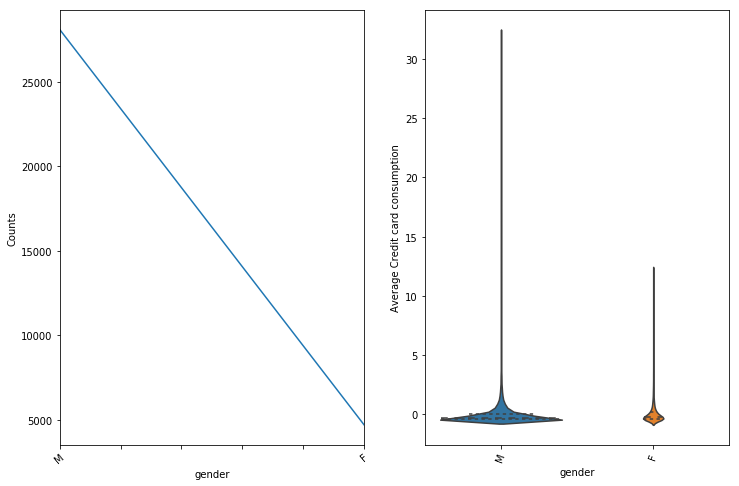

In [148]:
rel_cat(features, 'gender')

Males display on average higher credit card consumptions.

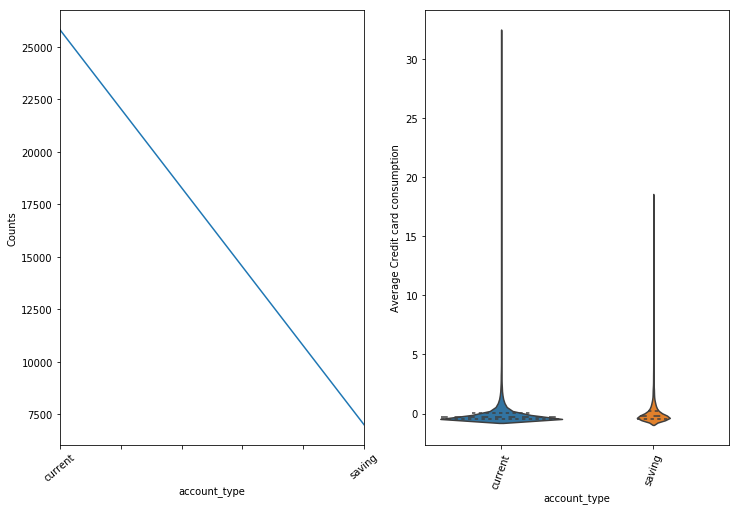

In [149]:
rel_cat(features, 'account_type')

As we presumed, current account types have higher average credit card consumption than savings account types. 

The column id is irrelevant for prediction purposes, so it will be removed from the training data.

In [ ]:
#drop id
features.drop(['id'], axis = 1, inplace = True)

In [152]:
features.head()

,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,...,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons,logcc_cons
0,saving,M,3.171031,-1.327477,-0.356707,-0.188504,-0.589465,-0.168633,-0.534914,-0.159730,...,-1.057510,-0.021747,-0.182131,-0.244125,0.275854,-0.984037,-0.365895,-0.036564,-0.512855,-1.481210
1,current,M,-0.346042,-1.215904,1.433687,-0.357194,0.654119,-0.168633,-0.505335,-0.003373,...,-0.337479,0.838830,0.153442,-0.063194,0.493403,0.240108,-0.142400,-0.017596,-0.393583,-0.349885
2,current,M,0.943552,-1.545310,-0.233169,-0.066776,0.306633,-0.221853,-0.500183,-0.396774,...,-0.607491,-0.277461,-0.094429,-0.150439,0.058305,0.240108,-0.194630,-0.036564,-0.389650,-0.330686
3,saving,M,0.943552,-1.710013,0.170025,-0.188504,-0.521139,-0.168633,0.174759,-0.159730,...,-1.147514,-0.232384,-0.230872,-0.223178,-0.594342,-1.137055,-0.325206,-0.031832,1.184238,1.494427
4,saving,F,-0.111570,-1.226530,-0.615723,-0.188504,-0.455042,-0.168633,-0.514368,-0.159730,...,-0.967507,-0.365978,-0.162481,-0.069571,-0.376793,-0.907528,0.009237,-0.036564,-0.402171,-0.393568


Now dummy variables will be assigned to categorical data ("one-hot encoding") so it can be used in the prediction models.

In [154]:
## One-hot encode categorical data in clean_train_df dataset
features = pd.get_dummies(features)

In [155]:
features.head()

,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,...,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons,logcc_cons,account_type_current,account_type_saving,gender_M,gender_F
0,3.171031,-1.327477,-0.356707,-0.188504,-0.589465,-0.168633,-0.534914,-0.159730,-0.673222,-0.890625,...,0.275854,-0.984037,-0.365895,-0.036564,-0.512855,-1.481210,0,1,1,0
1,-0.346042,-1.215904,1.433687,-0.357194,0.654119,-0.168633,-0.505335,-0.003373,0.191837,0.479414,...,0.493403,0.240108,-0.142400,-0.017596,-0.393583,-0.349885,1,0,1,0
2,0.943552,-1.545310,-0.233169,-0.066776,0.306633,-0.221853,-0.500183,-0.396774,-0.288751,-0.047524,...,0.058305,0.240108,-0.194630,-0.036564,-0.389650,-0.330686,1,0,1,0
3,0.943552,-1.710013,0.170025,-0.188504,-0.521139,-0.168633,0.174759,-0.159730,-0.000398,-0.363687,...,-0.594342,-1.137055,-0.325206,-0.031832,1.184238,1.494427,0,1,1,0
4,-0.111570,-1.226530,-0.615723,-0.188504,-0.455042,-0.168633,-0.514368,-0.159730,-0.673222,-0.258299,...,-0.376793,-0.907528,0.009237,-0.036564,-0.402171,-0.393568,0,1,0,1


Visualize numerical data with salary

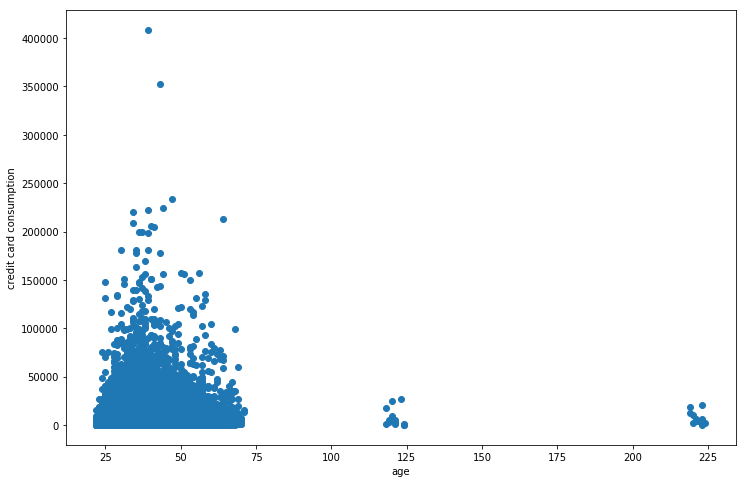

In [159]:
#scatter plot 
scatter_data(clear_train_df, 'age')

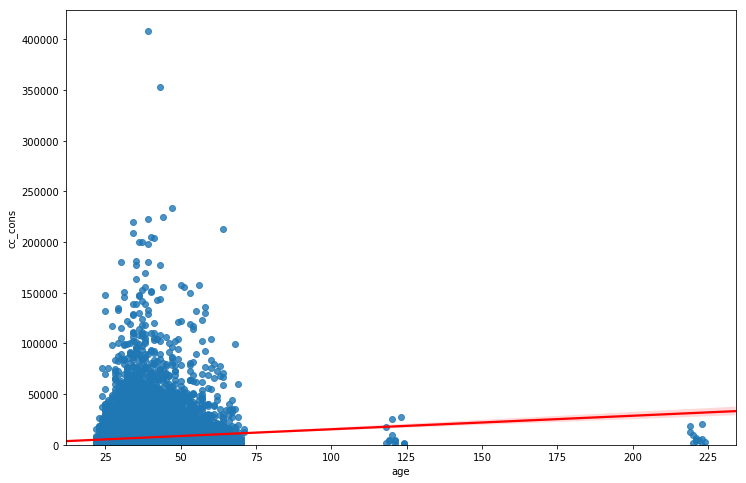

In [161]:
##Fit a regression line to age to visualize it as a predictor of cc_cons - 
reg_data(clear_train_df, 'age')

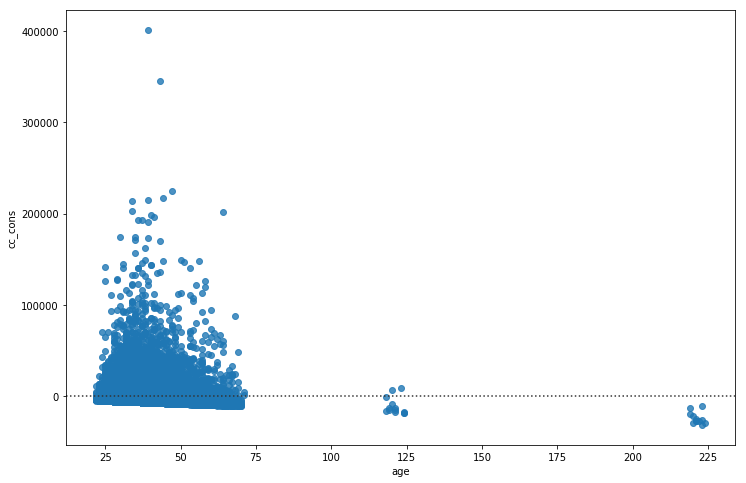

In [163]:
#Variance of age-
res_data(clear_train_df, 'age')

Variance in salary seems to decrease with increasing age.

Data seems to be spread away from the regression line.

Let us visualize the relationship between region_code & credit card consumption. 

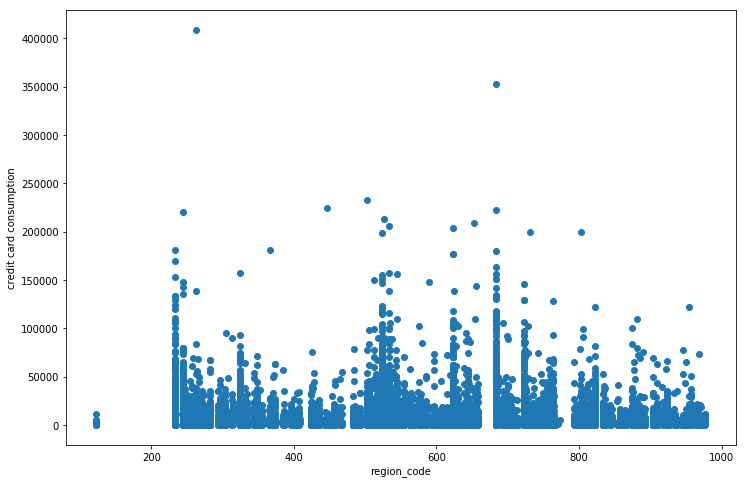

In [164]:
#scatter plot 
scatter_data(clear_train_df, 'region_code')

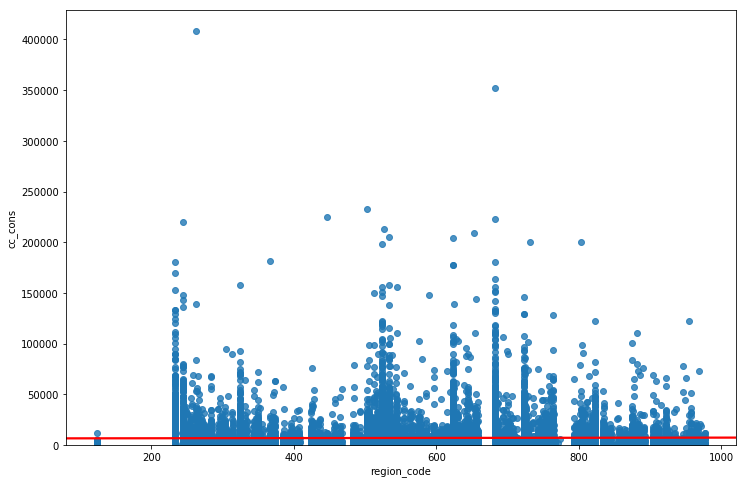

In [165]:
#Fit a regression line to region_code to visualize it as a predictor of cc_cons -
reg_data(clear_train_df, 'region_code')

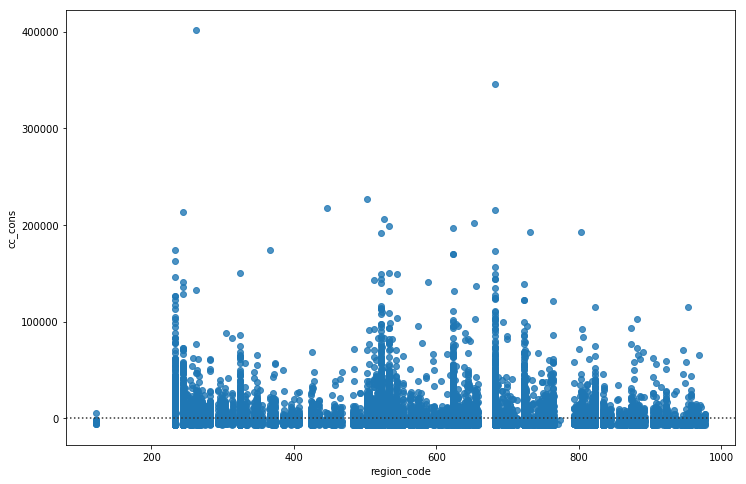

In [166]:
#variance of region_code
res_data(clear_train_df, 'region_code')

Data seems to be spread away from the regression line.

Let us visualize the relationship between emi_active & credit card consumption.

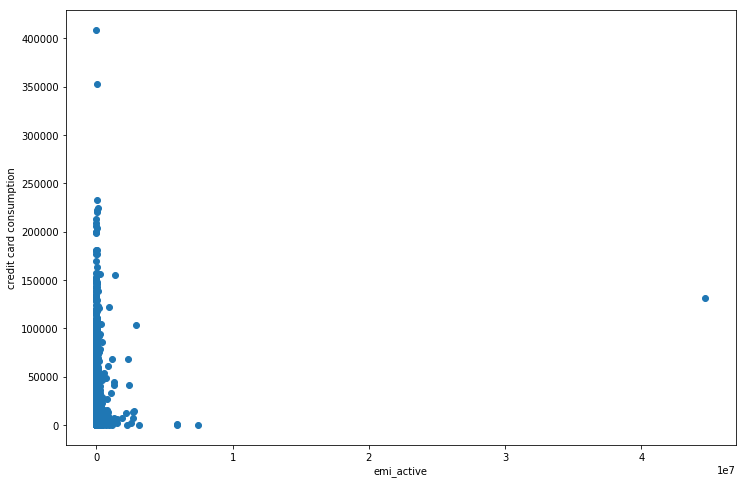

In [168]:
#scatter plot
scatter_data(clear_train_df, 'emi_active')

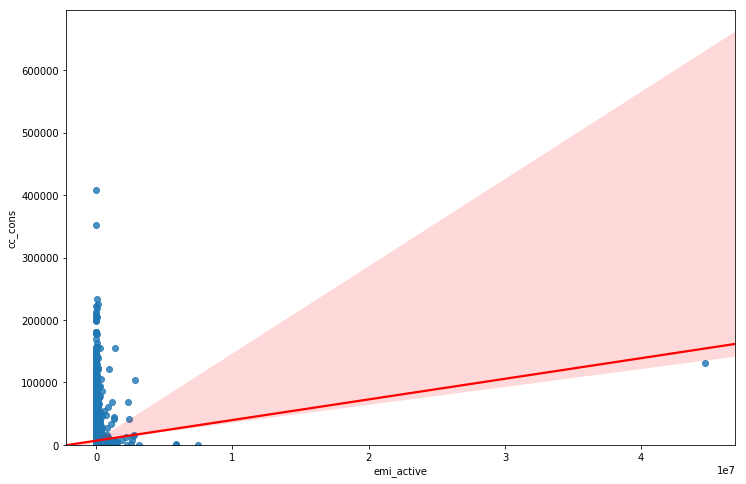

In [169]:
#fit a regression line to emi_active to visualize it as a predictor of cc_cons - 
reg_data(clear_train_df, 'emi_active')

Let us visualize the relationship between dc_cons_jun & credit card consumption.


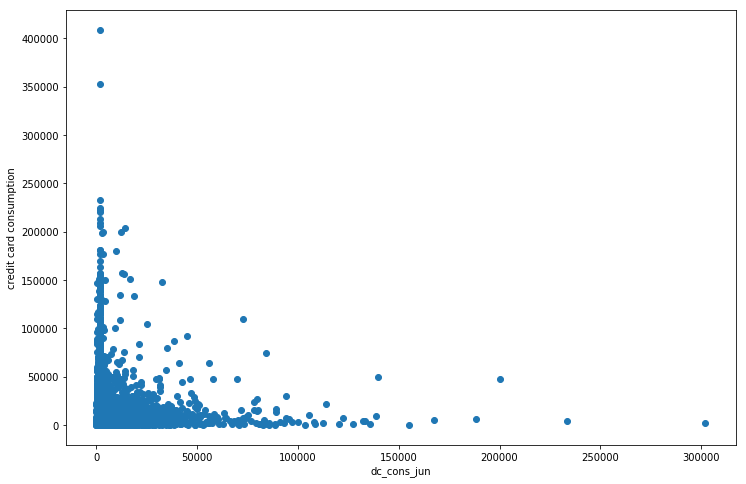

In [171]:
#scatter plot
scatter_data(clear_train_df, 'dc_cons_jun')

We can see that the average credit card consumption decreases with increase in debit card consumption in June

Correlation between all the features

Now that numerical values are assigned to all features we can see the correlation between all of them.

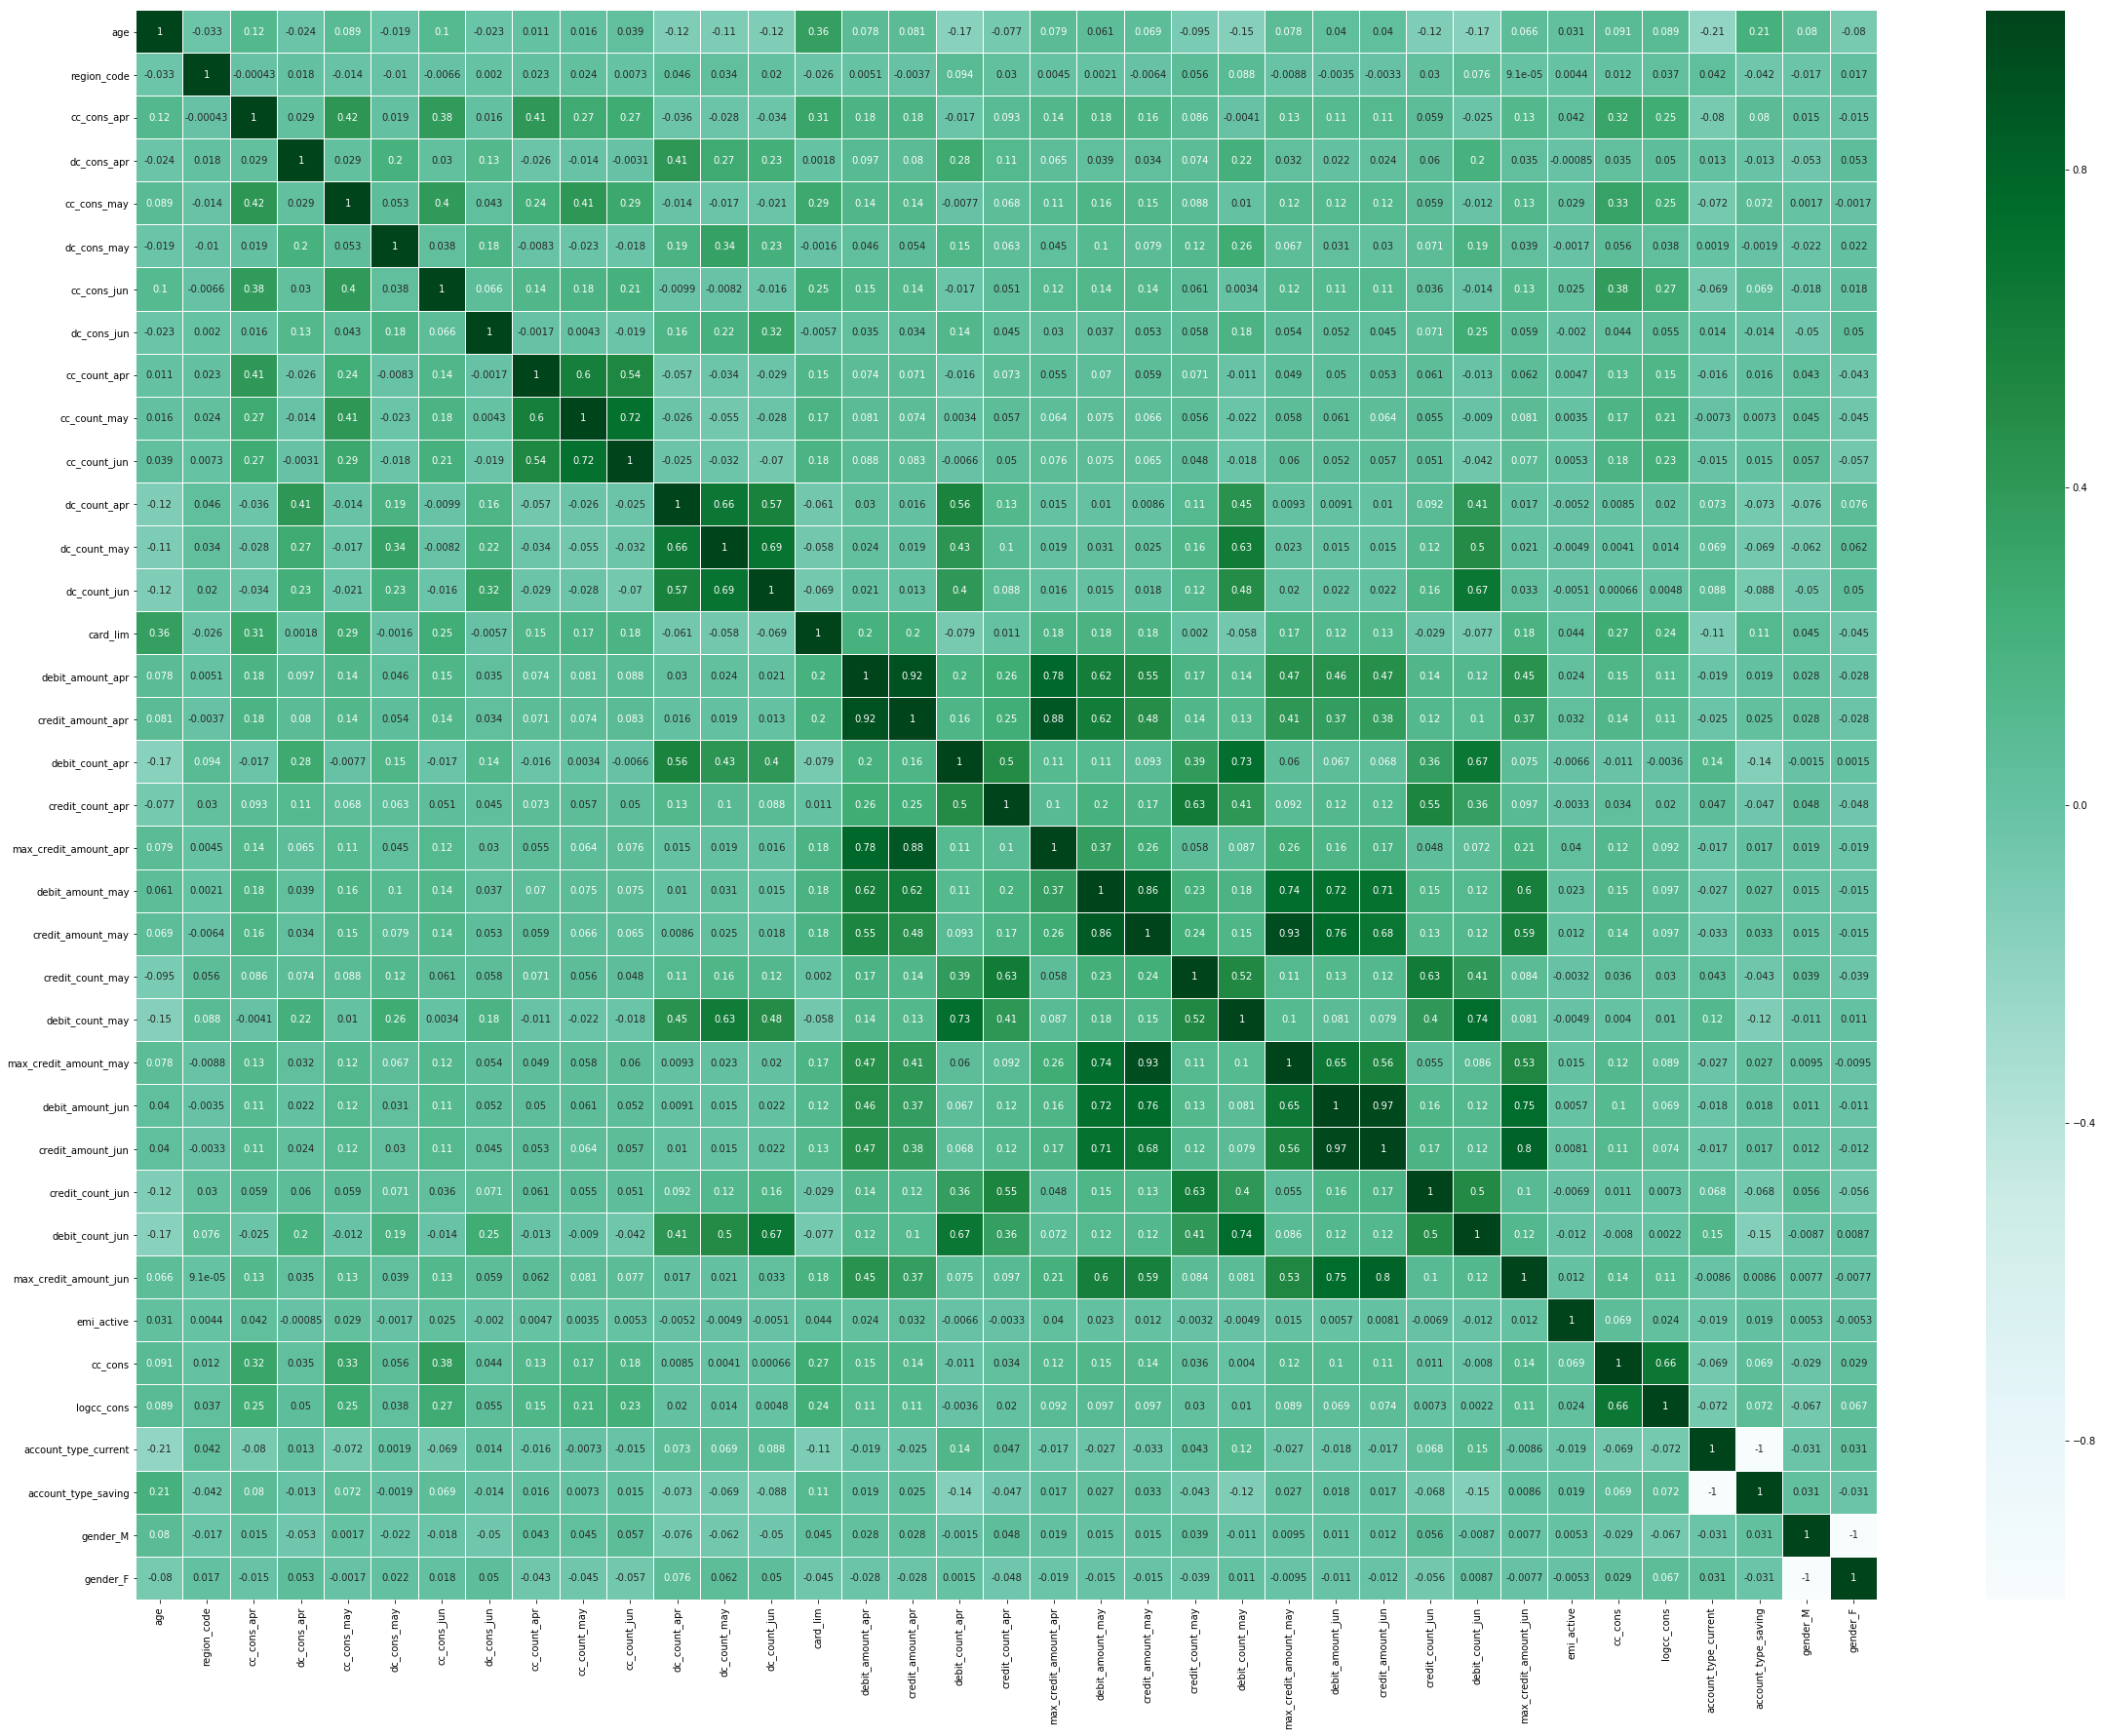

In [172]:
# Plot heatmap of all data with correlation coefficients visible
features_corr = features.corr()
plt.subplots(figsize = (40,30))
sns.heatmap(features_corr, cmap = 'BuGn', linewidth = .005, annot = True)

card_lim has the highest correlation with average credit card consumption. dc_count & cc_count also seem to be correlated with average credit card consumption.


## Multivariable Regression Modelling

After visually examining the predictors and their relationship with cc_cons, regression models can be fit using those predictors. Feature selection will be used to determine which combination of variables best predicts credit card Balance.


The Ordinary Least Square algorithm is used to create the linear regression model.

In [174]:
print features.columns

Index([u'age', u'region_code', u'cc_cons_apr', u'dc_cons_apr', u'cc_cons_may',
       u'dc_cons_may', u'cc_cons_jun', u'dc_cons_jun', u'cc_count_apr',
       u'cc_count_may', u'cc_count_jun', u'dc_count_apr', u'dc_count_may',
       u'dc_count_jun', u'card_lim', u'debit_amount_apr', u'credit_amount_apr',
       u'debit_count_apr', u'credit_count_apr', u'max_credit_amount_apr',
       u'debit_amount_may', u'credit_amount_may', u'credit_count_may',
       u'debit_count_may', u'max_credit_amount_may', u'debit_amount_jun',
       u'credit_amount_jun', u'credit_count_jun', u'debit_count_jun',
       u'max_credit_amount_jun', u'emi_active', u'cc_cons', u'logcc_cons',
       u'account_type_current', u'account_type_saving', u'gender_M',
       u'gender_F'],
      dtype='object')


In [176]:
mod0 = smf.ols('cc_cons ~ age + region_code + cc_cons_apr + dc_cons_apr + cc_cons_may + dc_cons_may + cc_cons_jun + dc_cons_jun + cc_count_apr + cc_count_may + cc_count_jun + dc_count_apr + dc_count_may + dc_count_jun + card_lim + debit_amount_apr + credit_amount_apr + debit_count_apr + credit_count_apr + max_credit_amount_apr + debit_amount_may + credit_amount_may + credit_count_may + debit_count_may + max_credit_amount_may + debit_amount_jun + credit_amount_jun + credit_count_jun + debit_count_jun + max_credit_amount_jun + emi_active + account_type_current + account_type_saving + gender_M + gender_F', data = features).fit()
mod0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cc_cons   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     289.3
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               0.00
Time:                        18:21:03   Log-Likelihood:                -42376.
No. Observations:               32820   AIC:                         8.482e+04
Df Residuals:                   32786   BIC:                         8.511e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.898e+11   7.83e+11      0.242      0.808   -1.34e+12    1.72e+12
age                      -0.0119      0.005     -2.211      0.027      -0.023      -0.001
region_code               0.0206      0.005      4.199      0.000       0.011       0.030
cc_cons_apr               0.1289      0.006     21.218      0.000       0.117       0.141
dc_cons_apr               0.0022      0.005      0.407      0.684      -0.008       0.013
cc_cons_may               0.1314      0.006     21.700      0.000       0.119       0.143
dc_cons_may               0.0331      0.005      6.241      0.000       0.023       0.044
cc_cons_jun               0.2298      0.006     41.175      0.000       0.219       0.241
dc_cons_jun               0.0108      0.005      2.077      0.038       0.001       0.021
cc_count_apr             -0.0365      0.007     -5.557      0.000      -0.049      -0.024
cc_count_may             -0.0033      0.008     -0.414      0.679      -0.019       0.012
cc_count_jun              0.0551      0.007      7.634      0.000       0.041       0.069
dc_count_apr              0.0237      0.008      2.994      0.003       0.008       0.039
dc_count_may             -0.0125      0.009     -1.345      0.179      -0.031       0.006
dc_count_jun              0.0107      0.009      1.193      0.233      -0.007       0.028
card_lim                  0.1131      0.006     19.973      0.000       0.102       0.124
debit_amount_apr          0.0091      0.014      0.630      0.529      -0.019       0.037
credit_amount_apr         0.0161      0.020      0.816      0.415      -0.023       0.055
debit_count_apr          -0.0194      0.009     -2.088      0.037      -0.038      -0.001
credit_count_apr          0.0039      0.007      0.530      0.596      -0.011       0.018
max_credit_amount_apr     0.0070      0.012      0.578      0.563      -0.017       0.031
debit_amount_may         -0.0283      0.014     -2.016      0.044      -0.056      -0.001
credit_amount_may         0.1126      0.024      4.646      0.000       0.065       0.160
credit_count_may         -0.0086      0.008     -1.067      0.286      -0.024       0.007
debit_count_may          -0.0037      0.011     -0.343      0.732      -0.025       0.018
max_credit_amount_may    -0.0484      0.017     -2.908      0.004      -0.081      -0.016
debit_amount_jun         -0.1332      0.025     -5.253      0.000      -0.183      -0.084
credit_amount_jun         0.1096      0.026      4.165      0.000       0.058       0.161
credit_count_jun         -0.0189      0.007     -2.590      0.010      -0.033      -0.005
debit_count_jun           0.0078      0.011      0.741      0.458      -0.013       0.028
max_credit_amount_jun     0.0283      0.009      3.223      0.001       0.011       0.045
emi_active             

The features that don't seem to be stastically significant are - gender_F, gender_M, account_type_saving, account_type_current, debit_count_jun, debit_count_may, credit_count_may, max_credit_amount_apr, credit_count_apr, credit_amount_apr, debit_amount_apr, dc_count_jun, dc_count_may, cc_count_may & dc_cons_apr

In [177]:
features_ols = features.drop(['gender_F', 'gender_M', 'account_type_saving', 'account_type_current', 'debit_count_jun', 'debit_count_may', 'credit_count_may', 'max_credit_amount_apr', 'credit_count_apr', 'credit_amount_apr', 'debit_amount_apr', 'dc_count_jun', 'dc_count_may', 'cc_count_may', 'dc_cons_apr'], axis = 1)

In [178]:
features_ols.head()

,age,region_code,cc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_jun,dc_count_apr,...,debit_amount_may,credit_amount_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,max_credit_amount_jun,emi_active,cc_cons,logcc_cons
0,3.171031,-1.327477,-0.356707,-0.589465,-0.168633,-0.534914,-0.159730,-0.673222,-0.798244,-0.229018,...,-0.225300,0.198825,-0.021747,-0.182131,-0.244125,0.275854,-0.365895,-0.036564,-0.512855,-1.481210
1,-0.346042,-1.215904,1.433687,0.654119,-0.168633,-0.505335,-0.003373,0.191837,-0.099477,-0.712805,...,0.212337,0.512897,0.838830,0.153442,-0.063194,0.493403,-0.142400,-0.017596,-0.393583,-0.349885
2,0.943552,-1.545310,-0.233169,0.306633,-0.221853,-0.500183,-0.396774,-0.288751,-0.536207,-0.229018,...,-0.278116,-0.275770,-0.277461,-0.094429,-0.150439,0.058305,-0.194630,-0.036564,-0.389650,-0.330686
3,0.943552,-1.710013,0.170025,-0.521139,-0.168633,0.174759,-0.159730,-0.000398,-0.536207,-0.229018,...,-0.255340,-0.294098,-0.232384,-0.230872,-0.223178,-0.594342,-0.325206,-0.031832,1.184238,1.494427
4,-0.111570,-1.226530,-0.615723,-0.455042,-0.168633,-0.514368,-0.159730,-0.673222,-0.274169,-0.229018,...,-0.321800,-0.379103,-0.365978,-0.162481,-0.069571,-0.376793,0.009237,-0.036564,-0.402171,-0.393568


In [179]:
features_nolog = features.drop(['logcc_cons'], axis = 1)

In [180]:
features_ols_nolog = features_ols.drop(['logcc_cons'], axis = 1)

To create a basic training model, two variables will be assigned for the model to use. Twenty percent of the training data will be split into testing data that we can use to test the model with data for which the salaries are already known.

In [181]:
#Split the data and assign 'cc_cons' to 'cc_df' and the rest of the features to 'feat_df'. 
feat_df = features_nolog[features_nolog.loc[ :, features_nolog.columns != 'cc_cons'].columns]
cc_df = features_nolog['cc_cons']
feat_train, feat_test, cc_train, cc_test = train_test_split(feat_df, cc_df, test_size = 0.2, random_state = 1)

In [182]:
#View inputs and outputs of training model
print 'Inputs- \n', feat_train.head()
print 'Outputs- \n', cc_train.head()

Inputs- 
            age  region_code  cc_cons_apr  dc_cons_apr  cc_cons_may  \
19856 -0.346042     0.107034    -0.404714    -0.188504     0.198296   
32    -0.111570     0.680838    -0.595627     0.153043    -0.336890   
19277  0.122901     1.892203     0.472589    -0.188504     1.248970   
18418 -0.228806    -1.226530     0.341984    -0.188504     1.256154   
15789 -0.111570    -1.646257    -0.340516    -0.188504    -0.229853   

       dc_cons_may  cc_cons_jun  dc_cons_jun  cc_count_apr  cc_count_may  ...  \
19856    -0.168633     0.256343    -0.159730      0.287955     -0.258299  ...   
32       -0.361429    -0.538159    -0.350824     -0.769339     -0.890625  ...   
19277    -0.168633    -0.423659    -0.159730      0.576308      1.427903  ...   
18418    -0.217061    -0.262634    -0.159730     -0.192634     -0.679850  ...   
15789    -0.169040    -0.471431     0.406473      1.056896      0.374027  ...   

       debit_amount_jun  credit_amount_jun  credit_count_jun  debit_count_jun

We will use linear regression here as cc_cons is a continious variable. With all the data, we see that this is a case of Supervised Regression learning. We will establish the baseline model by appling Linear Regression to feat_train, cc_train.

In [184]:
#Create Linear Regression Object and fit the model
lm = LinearRegression()
lm.fit(feat_train,cc_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Next, we will view the coefficients of our model -

In [186]:
#View coeff of Linear Regression object 
print(lm.intercept_)
print(lm.coef_)

-77494475535.9014
[-1.32713444e-02  2.34099230e-02  1.22503015e-01  6.60048417e-03
  1.19990598e-01  3.78844299e-02  2.14129595e-01  1.22458711e-02
 -3.29325203e-02 -5.50080672e-04  5.29872773e-02  2.37607284e-02
 -1.63578667e-02  9.25753765e-03  1.18944072e-01 -6.51421092e-03
  3.66097509e-02 -1.16425095e-02  9.04791281e-05  1.55326843e-03
 -4.40248252e-02  1.41168343e-01 -5.54547730e-03 -5.11294285e-03
 -6.72414379e-02 -1.55127339e-01  1.31364671e-01 -1.13774780e-02
 -1.87086683e-03  3.58065227e-02  4.88825389e-02  7.53016551e+10
  7.53016551e+10  2.19282041e+09  2.19282041e+09]


Now that the baseline model is created, it can predict the average salary consumption. The variable yhat is used to store the predictions using the training data.

In [187]:
#predict cc_cons using training data
yhat_train = lm.predict(feat_train)

#View first five predictions -
print 'First five predictions:' , yhat_train[0:5]

First five predictions: [-0.07829285 -0.2824707   0.29870605  0.24237061 -0.35673523]


Mean squared error (MSE) will be evaluated now along with accuracy and r-squared to evaluate the baseline model's performance and to determine if the subsequent models improve over the established baseline model.

In [188]:
#print MSE - 
print 'Mean Squared Error of our prediction model', mean_squared_error(cc_train, yhat_train)

Mean Squared Error of our prediction model 0.7762126233888715


In [189]:
# accurace of the baseline model using 5-cross validation method -
score = cross_val_score(lm, feat_train, cc_train, cv = 5)
print '5-Cross Validation accuracy', (np.mean(score)), (np.std(score))

5-Cross Validation accuracy 0.19664910002957664 0.0410637327666401


In [190]:
#Split the data and assign 'cc_cons' to 'cc_df_ols' and the rest of the features to 'feat_df_ols'. 
feat_df_ols = features_ols_nolog[features_ols_nolog.loc[ :, features_ols_nolog.columns != 'cc_cons'].columns]
cc_df_ols = features_ols_nolog['cc_cons']
feat_train_ols, feat_test_ols, cc_train_ols, cc_test_ols = train_test_split(feat_df_ols, cc_df_ols, test_size = 0.2, random_state = 1)

In [193]:
#Create Linear Regression Object and fit the model
lm1 = LinearRegression()
lm1.fit(feat_train_ols,cc_train_ols)
lm1

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [194]:
#predict cc_cons using training data
yhat_train_ols = lm1.predict(feat_train_ols)

#View first five predictions -
print 'First five predictions:' , yhat_train_ols[0:5]

First five predictions: [-0.05998731 -0.35401663  0.27247851  0.21246705 -0.33318186]


In [195]:
#print MSE - 
print 'Mean Squared Error of our prediction model', mean_squared_error(cc_train_ols, yhat_train_ols)

Mean Squared Error of our prediction model 0.7780385536032485


In [203]:
print 100*np.log(mean_squared_error(cc_train_ols, yhat_train_ols))

-25.09792012715825


In [196]:
# accurace of the baseline model using 5-cross validation method -
score = cross_val_score(lm1, feat_train_ols, cc_train_ols, cv = 5)
print '5-Cross Validation accuracy', (np.mean(score)), (np.std(score))

5-Cross Validation accuracy 0.19846690353327837 0.04075664769710481
